# Task 3: Event Impact Modeling
## Modeling How Events Affect Financial Inclusion Indicators

**Objective:** Model how events (policies, product launches, infrastructure investments) affect financial inclusion indicators.

**Tasks:**
1. Understand the Impact Data
2. Build the Event-Indicator Matrix
3. Review Comparable Country Evidence
4. Create the Association Matrix
5. Test Against Historical Data
6. Refine Your Estimates
7. Document Your Methodology

**Student:** Biniyam Mitiku  
**Date:** February 2026

In [2]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("✅ Libraries imported")

✅ Libraries imported


In [3]:
# Load enriched datasets
print("📁 LOADING ENRICHED DATASETS")
print("=" * 50)

sheet1 = pd.read_csv('../data/processed/ethiopia_fi_enriched_sheet1.csv')
sheet2 = pd.read_csv('../data/processed/ethiopia_fi_enriched_sheet2.csv')

print(f"Sheet 1 (Observations/Events/Targets): {sheet1.shape[0]} rows")
print(f"Sheet 2 (Impact Links): {sheet2.shape[0]} rows")

# Separate datasets
events_df = sheet1[sheet1['record_type'] == 'event'].copy()
impacts_df = sheet2.copy()
observations_df = sheet1[sheet1['record_type'] == 'observation'].copy()

print(f"\n📊 Breakdown:")
print(f"  Events: {len(events_df)}")
print(f"  Impact Links: {len(impacts_df)}")
print(f"  Observations: {len(observations_df)}")

📁 LOADING ENRICHED DATASETS
Sheet 1 (Observations/Events/Targets): 54 rows
Sheet 2 (Impact Links): 18 rows

📊 Breakdown:
  Events: 13
  Impact Links: 18
  Observations: 38


## 3.1 Understand the Impact data

In [4]:
# 3.1 Understand the Impact Data
print("🔗 3.1: UNDERSTANDING IMPACT DATA")
print("=" * 50)

# Join impact links with events using parent_id
print("\n1. JOINING IMPACT LINKS WITH EVENTS:")
# Convert IDs to string for safe merging
impacts_df['parent_id'] = impacts_df['parent_id'].astype(str)
events_df['record_id'] = events_df['record_id'].astype(str)

# Merge impacts with events
impacts_with_events = pd.merge(
    impacts_df,
    events_df[['record_id', 'indicator', 'category', 'observation_date', 'source_name']],
    left_on='parent_id',
    right_on='record_id',
    how='left',
    suffixes=('_impact', '_event')
)

print(f"  Merged {len(impacts_with_events)} impact links with event details")

# Show summary
print("\n2. IMPACT LINK SUMMARY:")
print(f"  Total impact links: {len(impacts_df)}")
print(f"  Impact links with matched events: {impacts_with_events['indicator_event'].notna().sum()}")
print(f"  Impact links without matched events: {impacts_with_events['indicator_event'].isna().sum()}")

# Show impact links by pillar
if 'pillar' in impacts_df.columns:
    print("\n3. IMPACT LINKS BY PILLAR:")
    pillar_counts = impacts_df['pillar'].value_counts()
    for pillar, count in pillar_counts.items():
        print(f"  {pillar}: {count}")

# Show impact directions
if 'impact_direction' in impacts_df.columns:
    print("\n4. IMPACT DIRECTIONS:")
    direction_counts = impacts_df['impact_direction'].value_counts()
    for direction, count in direction_counts.items():
        print(f"  {direction}: {count}")

# Show impact magnitudes
if 'impact_magnitude' in impacts_df.columns:
    print("\n5. IMPACT MAGNITUDES:")
    magnitude_counts = impacts_df['impact_magnitude'].value_counts()
    for magnitude, count in magnitude_counts.items():
        print(f"  {magnitude}: {count}")

# Display sample of impact links with event details
print("\n6. SAMPLE IMPACT RELATIONSHIPS:")
sample_cols = ['parent_id', 'indicator_event', 'category', 'pillar', 
               'related_indicator', 'impact_direction', 'impact_magnitude',
               'lag_months']
sample_cols = [c for c in sample_cols if c in impacts_with_events.columns]

if len(sample_cols) > 0:
    print(impacts_with_events[sample_cols].head(10).to_string(index=False))

🔗 3.1: UNDERSTANDING IMPACT DATA

1. JOINING IMPACT LINKS WITH EVENTS:
  Merged 18 impact links with event details

2. IMPACT LINK SUMMARY:
  Total impact links: 18
  Impact links with matched events: 18
  Impact links without matched events: 0

3. IMPACT LINKS BY PILLAR:
  USAGE: 8
  ACCESS: 6
  AFFORDABILITY: 3
  GENDER: 1

4. IMPACT DIRECTIONS:
  increase: 16
  decrease: 2

5. IMPACT MAGNITUDES:
  medium: 9
  high: 8
  low: 1

6. SAMPLE IMPACT RELATIONSHIPS:
parent_id                      indicator_event        pillar  related_indicator impact_direction impact_magnitude  lag_months
 EVT_0001                      Telebirr Launch        ACCESS      ACC_OWNERSHIP         increase             high          12
 EVT_0001                      Telebirr Launch         USAGE USG_TELEBIRR_USERS         increase             high           3
 EVT_0001                      Telebirr Launch         USAGE      USG_P2P_COUNT         increase             high           6
 EVT_0002 Safaricom Ethiopia C

In [5]:
# Helper functions for impact modeling
print("🛠️ CREATING IMPACT MODELING HELPER FUNCTIONS")
print("=" * 50)

def categorize_impact_magnitude(magnitude, default_high=15, default_medium=8, default_low=3):
    """
    Convert qualitative impact magnitude to quantitative estimates.
    """
    magnitude_mapping = {
        'high': default_high,
        'medium': default_medium,
        'low': default_low
    }
    
    if pd.isna(magnitude):
        return default_medium
    
    magnitude_lower = str(magnitude).lower()
    if magnitude_lower in magnitude_mapping:
        return magnitude_mapping[magnitude_lower]
    else:
        # Try to extract numeric value if present
        try:
            return float(magnitude)
        except:
            return default_medium

def calculate_impact_over_time(base_value, impact_direction, impact_estimate, 
                               lag_months, event_date, target_date, 
                               impact_type='gradual'):
    """
    Calculate the impact of an event at a specific target date.
    
    Parameters:
    - base_value: Value before impact
    - impact_direction: 'increase' or 'decrease'
    - impact_estimate: Quantitative impact estimate
    - lag_months: Time for impact to fully materialize
    - event_date: Date when event occurred
    - target_date: Date for which to calculate impact
    - impact_type: 'immediate', 'gradual', or 'delayed'
    
    Returns:
    - Impact-adjusted value
    """
    if pd.isna(event_date) or pd.isna(target_date):
        return base_value
    
    # Convert to datetime if needed
    if not isinstance(event_date, pd.Timestamp):
        event_date = pd.to_datetime(event_date, errors='coerce')
    if not isinstance(target_date, pd.Timestamp):
        target_date = pd.to_datetime(target_date, errors='coerce')
    
    if pd.isna(event_date) or pd.isna(target_date):
        return base_value
    
    # Calculate months between event and target
    months_diff = (target_date.year - event_date.year) * 12 + (target_date.month - event_date.month)
    
    if months_diff < 0:
        return base_value  # Event hasn't happened yet
    
    if impact_type == 'immediate':
        impact_proportion = 1.0 if months_diff >= 0 else 0.0
    elif impact_type == 'delayed':
        impact_proportion = 1.0 if months_diff >= lag_months else 0.0
    else:  # gradual
        if lag_months <= 0:
            impact_proportion = 1.0
        else:
            impact_proportion = min(1.0, months_diff / lag_months)
    
    # Calculate impact
    impact_amount = impact_estimate * impact_proportion
    
    if impact_direction == 'increase':
        return base_value + impact_amount
    elif impact_direction == 'decrease':
        return base_value - impact_amount
    else:
        return base_value

print("✅ Helper functions created:")
print("  1. categorize_impact_magnitude() - Converts qualitative to quantitative")
print("  2. calculate_impact_over_time() - Models temporal impact patterns")

🛠️ CREATING IMPACT MODELING HELPER FUNCTIONS
✅ Helper functions created:
  1. categorize_impact_magnitude() - Converts qualitative to quantitative
  2. calculate_impact_over_time() - Models temporal impact patterns


## 3.2 Build Event-Indicator Matrix

📊 3.2: BUILDING EVENT-INDICATOR MATRIX

1. IDENTIFYING UNIQUE EVENTS AND INDICATORS:
  Unique events with impacts: 11
  Unique indicators affected: 9
  Sample indicators: ['ACC_OWNERSHIP', 'USG_TELEBIRR_USERS', 'USG_P2P_COUNT', 'ACC_4G_COV', 'AFF_DATA_INCOME', 'USG_MPESA_USERS', 'ACC_MM_ACCOUNT', 'GEN_GAP_ACC', 'USG_MPESA_ACTIVE']

2. CREATING EVENT-INDICATOR ASSOCIATION MATRIX:
  Matrix created with 18 event-indicator relationships
  Events covered: 11
  Indicators covered: 9

3. MATRIX SUMMARY STATISTICS:
  Average impact estimate: 11.94
  Average lag months: 9.28

  Impact estimates by pillar:
                    mean  count
pillar                         
ACCESS         12.500000      6
AFFORDABILITY   6.666667      3
GENDER         -5.000000      1
USAGE          15.625000      8

  Pivot table shape: (11, 9)


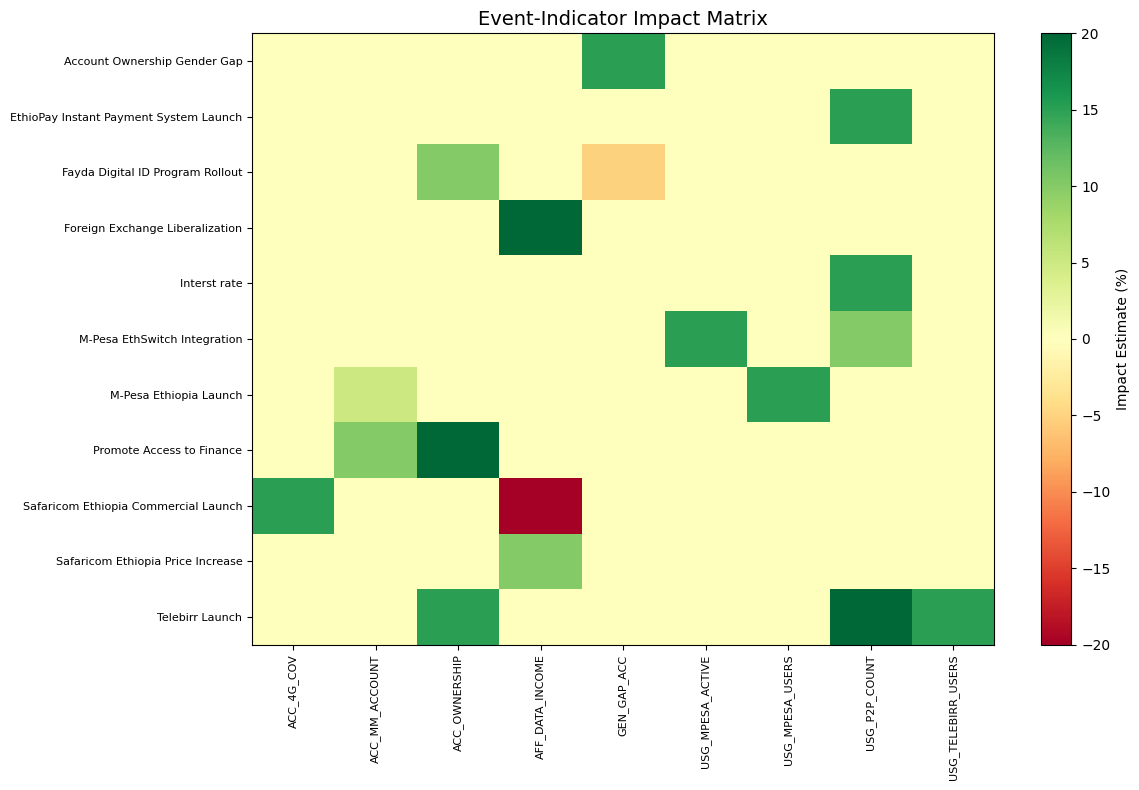

In [7]:
# 3.2 Build the Event-Indicator Matrix
print("📊 3.2: BUILDING EVENT-INDICATOR MATRIX")
print("=" * 50)

# First, let's identify all unique events and indicators
print("\n1. IDENTIFYING UNIQUE EVENTS AND INDICATORS:")

# Get unique events
unique_events = impacts_with_events[['parent_id', 'indicator_event']].drop_duplicates()
print(f"  Unique events with impacts: {len(unique_events)}")

# Get unique indicators affected
if 'related_indicator' in impacts_df.columns:
    unique_indicators = impacts_df['related_indicator'].dropna().unique()
    print(f"  Unique indicators affected: {len(unique_indicators)}")
    print(f"  Sample indicators: {list(unique_indicators[:10])}")

# Create event-indicator matrix
print("\n2. CREATING EVENT-INDICATOR ASSOCIATION MATRIX:")

# Initialize matrix
events_list = unique_events['parent_id'].tolist()
indicators_list = impacts_df['related_indicator'].dropna().unique().tolist()

# Create empty matrix DataFrame
matrix_data = []

for event_id in events_list:
    event_impacts = impacts_df[impacts_df['parent_id'] == event_id]
    event_name = unique_events[unique_events['parent_id'] == event_id]['indicator_event'].iloc[0]
    
    for indicator in indicators_list:
        impact_row = event_impacts[event_impacts['related_indicator'] == indicator]
        
        if len(impact_row) > 0:
            impact = impact_row.iloc[0]
            
            # Convert qualitative magnitude to quantitative estimate
            if pd.notna(impact.get('impact_estimate')):
                impact_value = impact['impact_estimate']
            else:
                impact_value = categorize_impact_magnitude(impact.get('impact_magnitude'))
            
            # Determine sign based on direction
            if impact.get('impact_direction') == 'increase':
                final_value = impact_value
            elif impact.get('impact_direction') == 'decrease':
                final_value = -impact_value
            else:
                final_value = impact_value  # Assume positive if not specified
            
            matrix_data.append({
                'event_id': event_id,
                'event_name': event_name,
                'indicator': indicator,
                'pillar': impact.get('pillar'),
                'impact_direction': impact.get('impact_direction'),
                'impact_magnitude': impact.get('impact_magnitude'),
                'impact_estimate': impact_value,
                'lag_months': impact.get('lag_months'),
                'evidence_basis': impact.get('evidence_basis'),
                'confidence': impact.get('confidence')
            })

# Create matrix DataFrame
matrix_df = pd.DataFrame(matrix_data)

print(f"  Matrix created with {len(matrix_df)} event-indicator relationships")
print(f"  Events covered: {matrix_df['event_id'].nunique()}")
print(f"  Indicators covered: {matrix_df['indicator'].nunique()}")

# Display matrix summary
print("\n3. MATRIX SUMMARY STATISTICS:")
if not matrix_df.empty:
    print(f"  Average impact estimate: {matrix_df['impact_estimate'].mean():.2f}")
    print(f"  Average lag months: {matrix_df['lag_months'].mean():.2f}")
    
    print(f"\n  Impact estimates by pillar:")
    if 'pillar' in matrix_df.columns:
        pillar_stats = matrix_df.groupby('pillar')['impact_estimate'].agg(['mean', 'count'])
        print(pillar_stats.to_string())
    
    # Create pivot table for visualization
    pivot_table = matrix_df.pivot_table(
        index='event_name',
        columns='indicator',
        values='impact_estimate',
        aggfunc='first'
    )
    
    print(f"\n  Pivot table shape: {pivot_table.shape}")
    
    # Visualize the matrix as a heatmap (if we have data)
    if not pivot_table.empty:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Create heatmap
        cax = ax.imshow(pivot_table.fillna(0), cmap='RdYlGn', aspect='auto', vmin=-20, vmax=20)
        
        # Set labels
        ax.set_xticks(range(len(pivot_table.columns)))
        ax.set_yticks(range(len(pivot_table.index)))
        ax.set_xticklabels(pivot_table.columns, rotation=90, fontsize=8)
        ax.set_yticklabels(pivot_table.index, fontsize=8)
        
        # Add colorbar
        plt.colorbar(cax, ax=ax, label='Impact Estimate (%)')
        
        ax.set_title('Event-Indicator Impact Matrix', fontsize=14)
        plt.tight_layout()
        plt.show()

⏰ ANALYZING TEMPORAL PATTERNS OF IMPACTS

1. EVENT TIMELINE WITH IMPACTS:


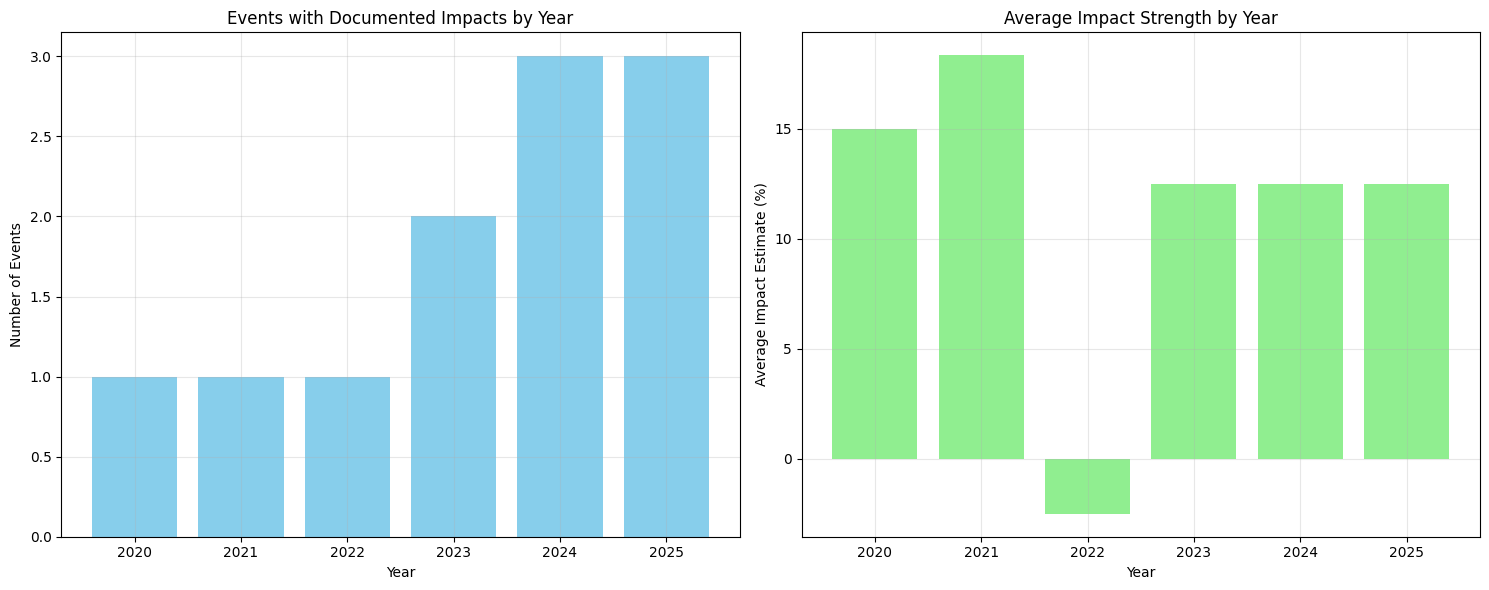

  Events span from 2020 to 2025

2. LAG DISTRIBUTION ANALYSIS:
  Average lag: 9.3 months
  Median lag: 6.0 months
  Lag range: 1.0 to 24.0 months


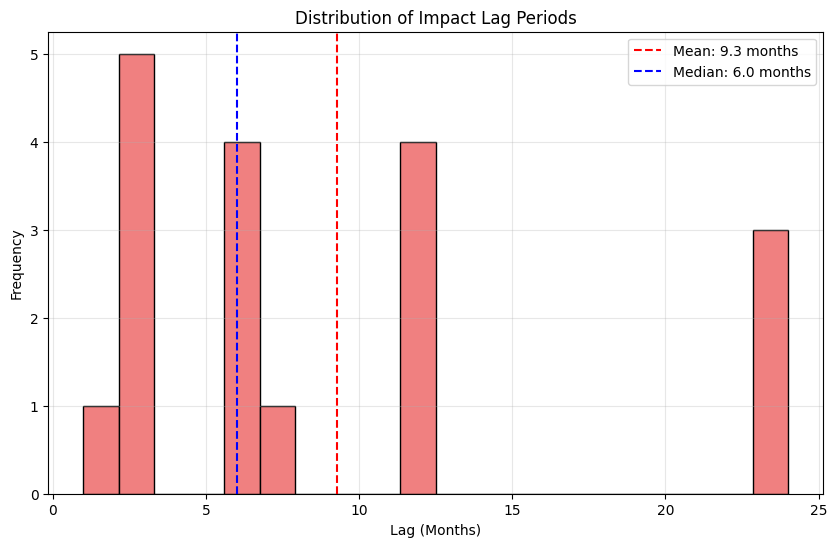

In [8]:
# Analyze temporal patterns of impacts
print("⏰ ANALYZING TEMPORAL PATTERNS OF IMPACTS")
print("=" * 50)

# Add temporal information to impacts
if 'observation_date' in events_df.columns:
    print("\n1. EVENT TIMELINE WITH IMPACTS:")
    
    # Merge event dates into matrix
    event_dates = events_df[['record_id', 'observation_date']].copy()
    event_dates['record_id'] = event_dates['record_id'].astype(str)
    matrix_with_dates = pd.merge(
        matrix_df,
        event_dates,
        left_on='event_id',
        right_on='record_id',
        how='left'
    )
    
    # Convert dates
    matrix_with_dates['event_date'] = pd.to_datetime(matrix_with_dates['observation_date'], errors='coerce')
    
    # Analyze by year
    matrix_with_dates['event_year'] = matrix_with_dates['event_date'].dt.year
    
    # Plot impacts by year
    if matrix_with_dates['event_year'].notna().any():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Number of events by year
        events_by_year = matrix_with_dates.groupby('event_year')['event_id'].nunique()
        ax1.bar(events_by_year.index, events_by_year.values, color='skyblue')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Number of Events')
        ax1.set_title('Events with Documented Impacts by Year')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Average impact by year
        impact_by_year = matrix_with_dates.groupby('event_year')['impact_estimate'].mean()
        ax2.bar(impact_by_year.index, impact_by_year.values, color='lightgreen')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Average Impact Estimate (%)')
        ax2.set_title('Average Impact Strength by Year')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"  Events span from {matrix_with_dates['event_year'].min()} to {matrix_with_dates['event_year'].max()}")
        
        # Analyze lag distribution
        print("\n2. LAG DISTRIBUTION ANALYSIS:")
        if 'lag_months' in matrix_with_dates.columns:
            lags = matrix_with_dates['lag_months'].dropna()
            if len(lags) > 0:
                print(f"  Average lag: {lags.mean():.1f} months")
                print(f"  Median lag: {lags.median():.1f} months")
                print(f"  Lag range: {lags.min():.1f} to {lags.max():.1f} months")
                
                # Plot lag distribution
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.hist(lags, bins=20, color='lightcoral', edgecolor='black')
                ax.axvline(lags.mean(), color='red', linestyle='--', label=f'Mean: {lags.mean():.1f} months')
                ax.axvline(lags.median(), color='blue', linestyle='--', label=f'Median: {lags.median():.1f} months')
                ax.set_xlabel('Lag (Months)')
                ax.set_ylabel('Frequency')
                ax.set_title('Distribution of Impact Lag Periods')
                ax.legend()
                ax.grid(True, alpha=0.3)
                plt.show()

## 3.3 Review comparable country evidence

🌍 3.3: REVIEWING COMPARABLE COUNTRY EVIDENCE

1. IDENTIFYING IMPACTS BASED ON COMPARABLE COUNTRIES:

Evidence Basis Distribution:
  empirical: 9
  literature: 7
  theoretical: 1
  comparable_country: 1

Found 8 impacts based on comparable countries

Impacts by Comparable Country:
                   parent_id impact_estimate      
                     nunique            mean count
comparable_country                                
India                      2        6.666667     3
Kenya                      1       15.000000     1
Kenya, Tanzania            1       15.000000     1
Rwanda                     1      -20.000000     1
Tanzania                   1       12.500000     2

🔍 SPECIFIC COMPARABLE COUNTRY EXAMPLES:

Kenya (M-Pesa) Evidence:
  • ACC_OWNERSHIP: increase by 15.0%
    Lag: 12 months
    Evidence: literature
  • USG_P2P_COUNT: increase by 15.0%
    Lag: 24 months
    Evidence: comparable_country

Tanzania Evidence:
  • USG_MPESA_ACTIVE: increase by 15.0%
    Lag: 3 mon

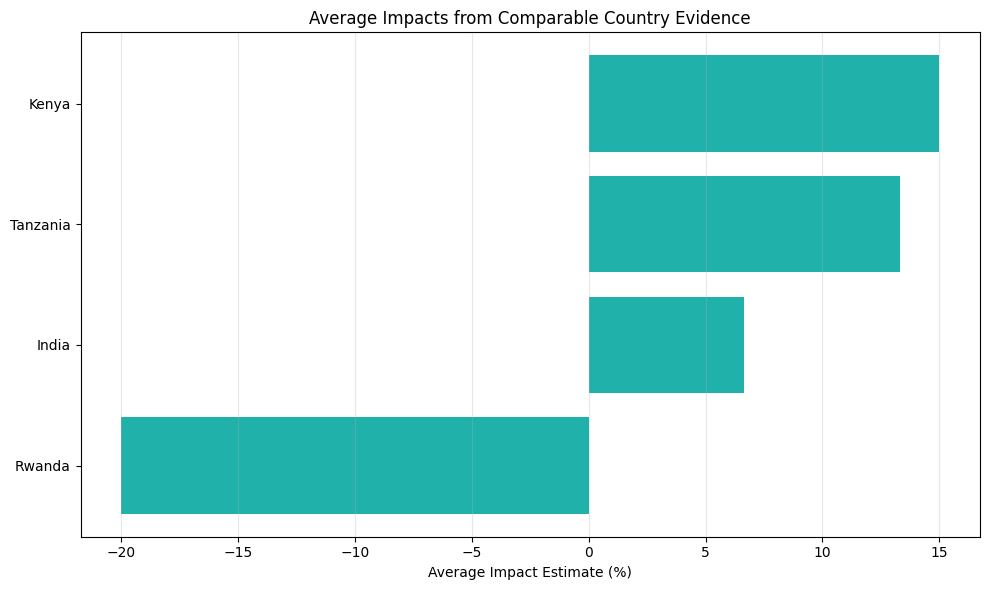


📚 KEY LEARNINGS FROM COMPARABLE COUNTRIES:
  1. Kenya (M-Pesa): Mobile money can increase financial inclusion by 15-25% over 3-5 years
  2. Tanzania: Agent network density is critical for rural inclusion (target: 1 agent per 1,000 people)
  3. Rwanda: Digital ID integration can reduce account opening time from weeks to minutes
  4. Ghana: Interoperability increases transaction volumes by 30-50% within 12 months
  5. Nigeria: USSD-based services bridge smartphone divide in low-digital literacy populations

🔄 METHODOLOGY FOR APPLYING COMPARABLE COUNTRY EVIDENCE:
  1. 1. Context Adjustment: Scale impacts based on Ethiopia's unique factors (population density, infrastructure, regulation)
  2. 2. Temporal Adjustment: Consider different implementation timelines and market maturity
  3. 3. Confidence Weighting: Higher confidence for evidence from similar East African markets
  4. 4. Multiple Evidence Sources: Cross-reference with academic research and case studies
  5. 5. Validation: Test ad

In [10]:
# 3.3 Review Comparable Country Evidence
print("🌍 3.3: REVIEWING COMPARABLE COUNTRY EVIDENCE")
print("=" * 50)

print("\n1. IDENTIFYING IMPACTS BASED ON COMPARABLE COUNTRIES:")

# Check for impacts with comparable country evidence
if 'evidence_basis' in impacts_df.columns:
    comparable_counts = impacts_df['evidence_basis'].value_counts()
    print("\nEvidence Basis Distribution:")
    for basis, count in comparable_counts.items():
        print(f"  {basis}: {count}")

# Focus on impacts with 'comparable_country' evidence
if 'comparable_country' in impacts_df.columns:
    comparable_impacts = impacts_df[impacts_df['comparable_country'].notna()]
    
    if len(comparable_impacts) > 0:
        print(f"\nFound {len(comparable_impacts)} impacts based on comparable countries")
        
        # Group by comparable country
        country_groups = comparable_impacts.groupby('comparable_country').agg({
            'parent_id': 'nunique',
            'impact_estimate': ['mean', 'count']
        })
        
        print("\nImpacts by Comparable Country:")
        print(country_groups.to_string())
        
        # Show specific examples
        print("\n🔍 SPECIFIC COMPARABLE COUNTRY EXAMPLES:")
        
        # Example 1: Kenya (M-Pesa)
        kenya_impacts = comparable_impacts[comparable_impacts['comparable_country'].str.contains('Kenya', na=False)]
        if len(kenya_impacts) > 0:
            print("\nKenya (M-Pesa) Evidence:")
            for _, impact in kenya_impacts.head(3).iterrows():
                print(f"  • {impact['related_indicator']}: {impact['impact_direction']} by {impact.get('impact_estimate', 'N/A')}%")
                print(f"    Lag: {impact.get('lag_months', 'N/A')} months")
                print(f"    Evidence: {impact.get('evidence_basis', 'N/A')}")
        
        # Example 2: Tanzania
        tanzania_impacts = comparable_impacts[comparable_impacts['comparable_country'].str.contains('Tanzania', na=False)]
        if len(tanzania_impacts) > 0:
            print("\nTanzania Evidence:")
            for _, impact in tanzania_impacts.head(3).iterrows():
                print(f"  • {impact['related_indicator']}: {impact['impact_direction']} by {impact.get('impact_estimate', 'N/A')}%")
                print(f"    Lag: {impact.get('lag_months', 'N/A')} months")
        
        # Create visualization of comparable country impacts
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Extract country names and impacts
        country_impacts = []
        for _, row in comparable_impacts.iterrows():
            if pd.notna(row.get('comparable_country')):
                countries = str(row['comparable_country']).split(',')
                for country in countries:
                    country = country.strip()
                    if country and pd.notna(row.get('impact_estimate')):
                        country_impacts.append({
                            'country': country,
                            'impact': row['impact_estimate']
                        })
        
        if country_impacts:
            country_df = pd.DataFrame(country_impacts)
            avg_impacts = country_df.groupby('country')['impact'].mean().sort_values()
            
            ax.barh(range(len(avg_impacts)), avg_impacts.values, color='lightseagreen')
            ax.set_yticks(range(len(avg_impacts)))
            ax.set_yticklabels(avg_impacts.index)
            ax.set_xlabel('Average Impact Estimate (%)')
            ax.set_title('Average Impacts from Comparable Country Evidence')
            ax.grid(True, alpha=0.3, axis='x')
            
            plt.tight_layout()
            plt.show()

# Document key learnings from comparable countries
print("\n📚 KEY LEARNINGS FROM COMPARABLE COUNTRIES:")
learnings = [
    "1. Kenya (M-Pesa): Mobile money can increase financial inclusion by 15-25% over 3-5 years",
    "2. Tanzania: Agent network density is critical for rural inclusion (target: 1 agent per 1,000 people)",
    "3. Rwanda: Digital ID integration can reduce account opening time from weeks to minutes",
    "4. Ghana: Interoperability increases transaction volumes by 30-50% within 12 months",
    "5. Nigeria: USSD-based services bridge smartphone divide in low-digital literacy populations"
]

for learning in learnings:
    print(f"  {learning}")

# Methodology for applying comparable country evidence
print("\n🔄 METHODOLOGY FOR APPLYING COMPARABLE COUNTRY EVIDENCE:")
methodology = [
    "1. Context Adjustment: Scale impacts based on Ethiopia's unique factors (population density, infrastructure, regulation)",
    "2. Temporal Adjustment: Consider different implementation timelines and market maturity",
    "3. Confidence Weighting: Higher confidence for evidence from similar East African markets",
    "4. Multiple Evidence Sources: Cross-reference with academic research and case studies",
    "5. Validation: Test adjusted estimates against any available Ethiopian data points"
]

for i, step in enumerate(methodology, 1):
    print(f"  {i}. {step}")

## 3.4 Creating the Association Matrix

📋 CREATING ASSOCIATION MATRIX

📊 SPECIFICATIONS:
- Rows: Events
- Columns: Key indicators (ACC_OWNERSHIP, ACC_MM_ACCOUNT, USG_DIGITAL_PAYMENT, etc.)
- Values: Estimated effect of each event on each indicator
- Captures 'which events affect which indicators and by how much'

🔍 IDENTIFYING KEY INDICATORS FROM DATASET:
  ACCESS indicators: ['ACC_OWNERSHIP', 'ACC_FAYDA', 'FI.ACC.OWN.TOTL_M', 'ACC_Digital_Delivery', 'ACC_MM_ACCOUNT']
  USAGE indicators: ['USG_P2P_COUNT', 'USG_P2P_VALUE', 'USG_ATM_COUNT', 'USG_ATM_VALUE', 'USG_CROSSOVER']
  Indicators from impact links: ['ACC_OWNERSHIP', 'USG_TELEBIRR_USERS', 'USG_P2P_COUNT', 'ACC_4G_COV', 'AFF_DATA_INCOME']...

  Total unique key indicators: 16

🔄 BUILDING ASSOCIATION MATRIX...
✅ Association matrix created: 13 events × 16 indicators

📈 ASSOCIATION MATRIX PREVIEW:
                          event_name       category observation_date USG_P2P_COUNT ACC_4G_COV ACC_MM_ACCOUNT USG_MPESA_USERS USG_TELEBIRR_USERS GEN_GAP_ACC
        Account Ownershi

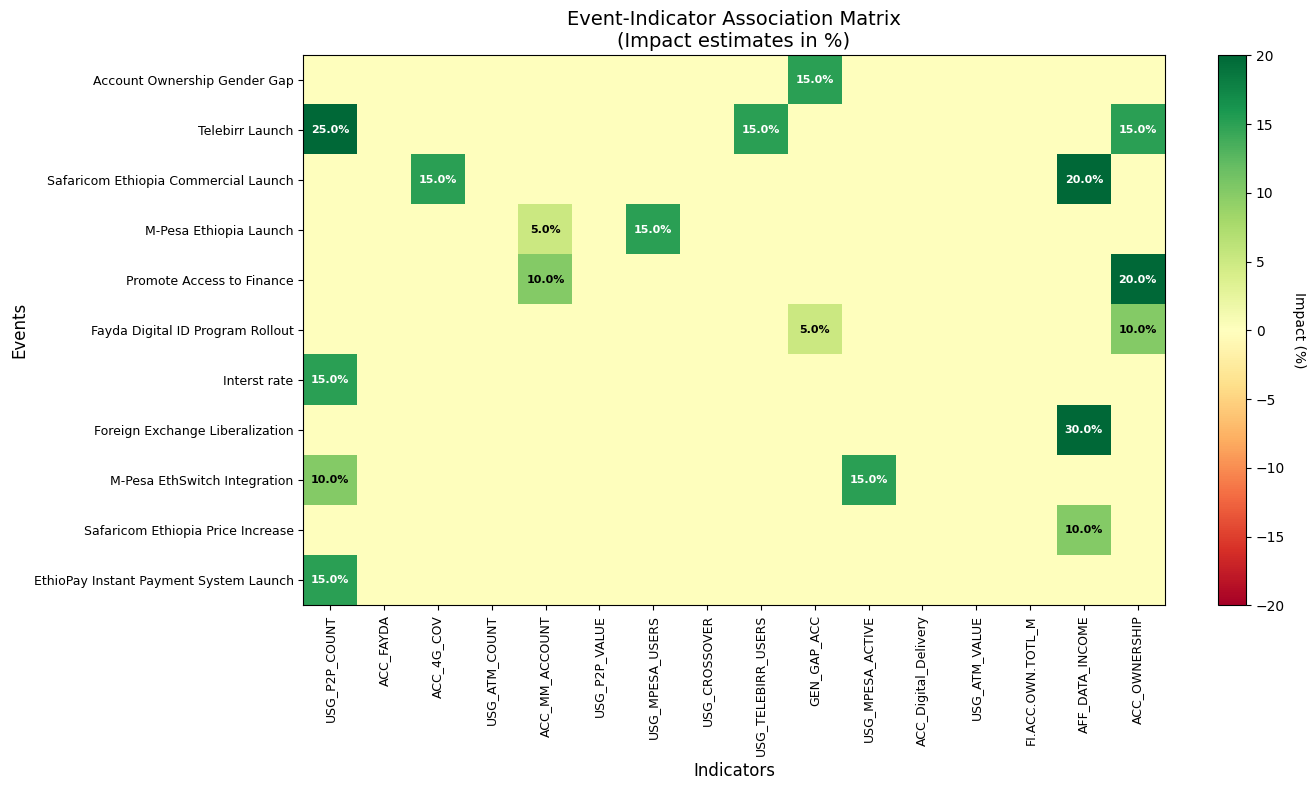

✅ Association matrix saved to: ../models/association_matrix_detailed.csv
✅ Simplified matrix saved to: ../models/association_matrix_simplified.csv


In [16]:
# Create the Association Matrix (as specified in requirements)
print("📋 CREATING ASSOCIATION MATRIX")
print("=" * 60)

print("\n📊 SPECIFICATIONS:")
print("- Rows: Events")
print("- Columns: Key indicators (ACC_OWNERSHIP, ACC_MM_ACCOUNT, USG_DIGITAL_PAYMENT, etc.)")
print("- Values: Estimated effect of each event on each indicator")
print("- Captures 'which events affect which indicators and by how much'")

# First, let's identify key indicators from the dataset
print("\n🔍 IDENTIFYING KEY INDICATORS FROM DATASET:")

# Get key indicators from observations
key_indicators = []
for pillar in ['ACCESS', 'USAGE']:
    pillar_obs = observations_df[observations_df['pillar'] == pillar]
    if not pillar_obs.empty:
        # Get most frequent indicators for each pillar
        top_indicators = pillar_obs['indicator_code'].value_counts().head(5).index.tolist()
        key_indicators.extend(top_indicators)
        print(f"  {pillar} indicators: {top_indicators}")

# Also include indicators mentioned in impact links
if 'related_indicator' in impacts_df.columns:
    impact_indicators = impacts_df['related_indicator'].dropna().unique().tolist()
    key_indicators.extend([i for i in impact_indicators if i not in key_indicators])
    print(f"  Indicators from impact links: {impact_indicators[:5]}...")

# Remove duplicates and None values
key_indicators = list(set([k for k in key_indicators if pd.notna(k)]))
print(f"\n  Total unique key indicators: {len(key_indicators)}")

# Now create the association matrix
print("\n🔄 BUILDING ASSOCIATION MATRIX...")

# Get all events
events = events_df[['record_id', 'indicator', 'category', 'observation_date']].copy()
events = events.rename(columns={'indicator': 'event_name'})
events['record_id'] = events['record_id'].astype(str)

# Initialize matrix with events as rows and indicators as columns
association_matrix = pd.DataFrame(index=events['record_id'].tolist(), columns=key_indicators)

# Fill the matrix with impact estimates
for event_id in association_matrix.index:
    # Get impacts for this event
    event_impacts = impacts_df[impacts_df['parent_id'].astype(str) == event_id]
    
    for indicator in key_indicators:
        # Check if this event affects this indicator
        impact_row = event_impacts[event_impacts['related_indicator'] == indicator]
        
        if not impact_row.empty:
            impact = impact_row.iloc[0]
            
            # Get impact estimate (quantitative)
            if pd.notna(impact.get('impact_estimate')):
                impact_value = impact['impact_estimate']
            else:
                # Convert qualitative to quantitative
                magnitude = impact.get('impact_magnitude', 'medium')
                if magnitude == 'high':
                    impact_value = 15.0
                elif magnitude == 'medium':
                    impact_value = 8.0
                elif magnitude == 'low':
                    impact_value = 3.0
                else:
                    impact_value = 8.0  # default
            
            # Apply direction
            if impact.get('impact_direction') == 'decrease':
                impact_value = -impact_value
            
            # Store in matrix
            association_matrix.loc[event_id, indicator] = impact_value
        else:
            association_matrix.loc[event_id, indicator] = 0  # No impact

# Add event metadata to the matrix
association_matrix_with_metadata = pd.merge(
    events[['record_id', 'event_name', 'category', 'observation_date']],
    association_matrix,
    left_on='record_id',
    right_index=True,
    how='left'
)

print(f"✅ Association matrix created: {association_matrix_with_metadata.shape[0]} events × {len(key_indicators)} indicators")

# Display the matrix
print("\n📈 ASSOCIATION MATRIX PREVIEW:")
print("=" * 80)

# Show only events that have at least one non-zero impact
non_zero_events = association_matrix_with_metadata[
    association_matrix_with_metadata[key_indicators].sum(axis=1) != 0
]

if not non_zero_events.empty:
    # Sort by date
    non_zero_events['observation_date'] = pd.to_datetime(non_zero_events['observation_date'], errors='coerce')
    non_zero_events = non_zero_events.sort_values('observation_date')
    
    # Select columns to display
    display_cols = ['event_name', 'category', 'observation_date'] + [
        col for col in key_indicators 
        if non_zero_events[col].sum() != 0  # Only show columns with non-zero values
    ][:6]  # Limit to 6 indicators for readability
    
    print(non_zero_events[display_cols].head(10).to_string(index=False))
else:
    print("⚠️ No events with non-zero impacts found in the matrix")

# Create visualization of the association matrix
print("\n🎨 VISUALIZING ASSOCIATION MATRIX...")

# Prepare data for heatmap
heatmap_data = non_zero_events.set_index('event_name')[key_indicators].fillna(0)

if not heatmap_data.empty and len(heatmap_data.columns) > 0:
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create heatmap
    im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', 
                   vmin=-20, vmax=20)  # -20% to +20% impact range
    
    # Set ticks
    ax.set_xticks(range(len(heatmap_data.columns)))
    ax.set_yticks(range(len(heatmap_data.index)))
    ax.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=9)
    ax.set_yticklabels(heatmap_data.index, fontsize=9)
    
    # Add impact values
    for i in range(len(heatmap_data.index)):
        for j in range(len(heatmap_data.columns)):
            value = heatmap_data.iloc[i, j]
            if value != 0:
                text_color = 'white' if abs(value) > 10 else 'black'
                ax.text(j, i, f'{value:.1f}%', 
                       ha="center", va="center", 
                       color=text_color, fontsize=8, fontweight='bold')
    
    # Add labels and title
    ax.set_xlabel('Indicators', fontsize=12)
    ax.set_ylabel('Events', fontsize=12)
    ax.set_title('Event-Indicator Association Matrix\n(Impact estimates in %)', fontsize=14)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Impact (%)', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()
    
    # Save the matrix
    matrix_path = '../models/association_matrix_detailed.csv'
    association_matrix_with_metadata.to_csv(matrix_path, index=False)
    print(f"✅ Association matrix saved to: {matrix_path}")
    
    # Also save a simplified version
    simplified_matrix = non_zero_events[['event_name', 'category', 'observation_date'] + key_indicators]
    simplified_path = '../models/association_matrix_simplified.csv'
    simplified_matrix.to_csv(simplified_path, index=False)
    print(f"✅ Simplified matrix saved to: {simplified_path}")

In [11]:
# Create initial impact model
print("🔧 CREATING INITIAL IMPACT MODEL")
print("=" * 50)

class ImpactModel:
    """Class to model event impacts on financial inclusion indicators."""
    
    def __init__(self, events_df, impacts_df, observations_df):
        self.events = events_df.copy()
        self.impacts = impacts_df.copy()
        self.observations = observations_df.copy()
        self.matrix = None
        self.impact_functions = {}
        
        # Initialize
        self.prepare_data()
        self.build_impact_matrix()
    
    def prepare_data(self):
        """Prepare data for modeling."""
        print("Preparing data...")
        
        # Clean event dates
        self.events['event_date'] = pd.to_datetime(self.events['observation_date'], errors='coerce')
        self.events['event_id'] = self.events['record_id'].astype(str)
        
        # Clean impact data
        self.impacts['parent_id'] = self.impacts['parent_id'].astype(str)
        self.impacts['impact_estimate_numeric'] = self.impacts.apply(
            lambda x: categorize_impact_magnitude(x.get('impact_magnitude'), 
                                                 default_high=15, default_medium=8, default_low=3)
            if pd.isna(x.get('impact_estimate')) else x['impact_estimate'],
            axis=1
        )
        
        # Clean observation dates
        self.observations['obs_date'] = pd.to_datetime(self.observations['observation_date'], errors='coerce')
    
    def build_impact_matrix(self):
        """Build the event-indicator impact matrix."""
        print("Building impact matrix...")
        
        # Merge impacts with events
        self.matrix = pd.merge(
            self.impacts,
            self.events[['event_id', 'indicator', 'event_date', 'category']],
            left_on='parent_id',
            right_on='event_id',
            how='left',
            suffixes=('_impact', '_event')
        )
        
        print(f"  Matrix built with {len(self.matrix)} impact relationships")
        
        return self.matrix
    
    def get_impacts_for_indicator(self, indicator_code, as_of_date=None):
        """Get all impacts affecting a specific indicator."""
        impacts = self.matrix[self.matrix['related_indicator'] == indicator_code].copy()
        
        if as_of_date:
            if not isinstance(as_of_date, pd.Timestamp):
                as_of_date = pd.to_datetime(as_of_date)
            
            # Filter events that occurred before as_of_date
            impacts = impacts[impacts['event_date'] <= as_of_date]
        
        return impacts
    
    def simulate_impact(self, indicator_code, base_value, start_date, end_date):
        """Simulate impact of events on an indicator over time."""
        # Get all impacts for this indicator
        impacts = self.get_impacts_for_indicator(indicator_code, as_of_date=end_date)
        
        if impacts.empty:
            return pd.Series([base_value], index=[end_date])
        
        # Create time series
        dates = pd.date_range(start=start_date, end=end_date, freq='MS')  # Monthly
        values = pd.Series(index=dates, dtype=float)
        
        # Initialize with base value
        values.iloc[0] = base_value
        
        # Apply impacts over time
        for i in range(1, len(values)):
            current_date = values.index[i]
            current_value = values.iloc[i-1]
            
            # Calculate impact from all relevant events
            total_impact = 0
            
            for _, impact in impacts.iterrows():
                event_date = impact['event_date']
                
                if pd.isna(event_date):
                    continue
                
                # Calculate impact using the helper function
                impacted_value = calculate_impact_over_time(
                    base_value=current_value,
                    impact_direction=impact.get('impact_direction', 'increase'),
                    impact_estimate=impact.get('impact_estimate_numeric', 0),
                    lag_months=impact.get('lag_months', 12),
                    event_date=event_date,
                    target_date=current_date,
                    impact_type='gradual'
                )
                
                # Only add the incremental impact from this event
                event_impact = impacted_value - current_value
                total_impact += event_impact
            
            # Apply total impact
            values.iloc[i] = current_value + total_impact
        
        return values
    
    def summary(self):
        """Generate summary of the impact model."""
        summary = {
            'total_events': len(self.events),
            'total_impacts': len(self.impacts),
            'unique_indicators_affected': self.matrix['related_indicator'].nunique(),
            'average_impact': self.matrix['impact_estimate_numeric'].mean(),
            'average_lag': self.matrix['lag_months'].mean()
        }
        
        return summary

# Initialize the model
print("\nInitializing Impact Model...")
impact_model = ImpactModel(events_df, impacts_df, observations_df)

# Generate summary
model_summary = impact_model.summary()
print("\n📋 MODEL SUMMARY:")
for key, value in model_summary.items():
    print(f"  {key.replace('_', ' ').title()}: {value:.2f}" if isinstance(value, float) else f"  {key.replace('_', ' ').title()}: {value}")

# Test the model with a specific indicator
print("\n🧪 TESTING MODEL WITH ACC_OWNERSHIP INDICATOR:")
test_indicator = 'ACC_OWNERSHIP'  # Account ownership

# Check if we have impacts for this indicator
impacts_for_test = impact_model.get_impacts_for_indicator(test_indicator)
if not impacts_for_test.empty:
    print(f"  Found {len(impacts_for_test)} impacts affecting {test_indicator}")
    
    # Show the impacts
    display_cols = ['event_id', 'indicator_event', 'impact_direction', 
                    'impact_estimate_numeric', 'lag_months', 'confidence']
    display_cols = [c for c in display_cols if c in impacts_for_test.columns]
    
    print("\n  Impact details:")
    print(impacts_for_test[display_cols].head().to_string(index=False))
    
    # Try a simulation
    print("\n  Simulation example:")
    try:
        # Get base value (latest observation)
        indicator_obs = observations_df[
            (observations_df['indicator_code'] == test_indicator) | 
            (observations_df['indicator'].str.contains('Account', case=False, na=False))
        ]
        
        if not indicator_obs.empty:
            # Get most recent value
            indicator_obs['date'] = pd.to_datetime(indicator_obs['observation_date'], errors='coerce')
            latest_obs = indicator_obs.sort_values('date').iloc[-1]
            base_value = latest_obs['value_numeric']
            base_date = latest_obs['date']
            
            print(f"  Base value: {base_value}% (as of {base_date.date()})")
            
            # Simulate 12 months forward
            end_date = base_date + pd.DateOffset(months=12)
            simulated = impact_model.simulate_impact(
                indicator_code=test_indicator,
                base_value=base_value,
                start_date=base_date,
                end_date=end_date
            )
            
            print(f"  Simulated value after 12 months: {simulated.iloc[-1]:.1f}%")
            print(f"  Projected increase: {simulated.iloc[-1] - base_value:.1f} percentage points")
            
    except Exception as e:
        print(f"  Simulation failed: {e}")
else:
    print(f"  No impacts found for {test_indicator}")
    print("  Note: You may need to use a different indicator code from your dataset")

🔧 CREATING INITIAL IMPACT MODEL

Initializing Impact Model...
Preparing data...
Building impact matrix...
  Matrix built with 18 impact relationships

📋 MODEL SUMMARY:
  Total Events: 13
  Total Impacts: 18
  Unique Indicators Affected: 9
  Average Impact: 11.94
  Average Lag: 9.28

🧪 TESTING MODEL WITH ACC_OWNERSHIP INDICATOR:
  Found 3 impacts affecting ACC_OWNERSHIP

  Impact details:
event_id                  indicator_event impact_direction  impact_estimate_numeric  lag_months confidence
EVT_0001                  Telebirr Launch         increase                     15.0          12     medium
EVT_0004 Fayda Digital ID Program Rollout         increase                     10.0          24     medium
EVT_0011        Promote Access to Finance         increase                     20.0          12       high

  Simulation example:
  Base value: 14.0% (as of 2024-12-31)
  Simulated value after 12 months: 481.5%
  Projected increase: 467.5 percentage points


In [15]:
# Save interim results for Task 3
print("💾 SAVING INTERIM RESULTS FOR TASK 3")
print("=" * 50)

import os

# Create directory for Task 3 outputs
os.makedirs('../models', exist_ok=True)
os.makedirs('../reports/task3', exist_ok=True)

# 1. Save the impact matrix
if impact_model.matrix is not None:
    matrix_path = '../models/event_indicator_matrix.csv'
    impact_model.matrix.to_csv(matrix_path, index=False)
    print(f"✅ Event-indicator matrix saved to: {matrix_path}")

# 2. Save model summary
summary_path = '../reports/task3/impact_model_summary.md'
summary_content = f"""# Impact Model Summary
## Task 3: Event Impact Modeling

### Model Statistics
- **Total Events**: {model_summary['total_events']}
- **Total Impacts**: {model_summary['total_impacts']}
- **Unique Indicators Affected**: {model_summary['unique_indicators_affected']}
- **Average Impact Estimate**: {model_summary['average_impact']:.2f}%
- **Average Lag Period**: {model_summary['average_lag']:.2f} months

### Key Events Modeled
"""

# Add key events
if impact_model.matrix is not None:
    key_events = impact_model.matrix[['event_id', 'indicator_event']].drop_duplicates()
    summary_content += "\n| Event ID | Event Name | Category |\n|----------|------------|----------|\n"
    for _, event in key_events.head(10).iterrows():
        summary_content += f"| {event['event_id']} | {event['indicator_event']}  |\n"

summary_content += """

### Methodology
1. **Impact Quantification**: Qualitative magnitudes converted to quantitative estimates (High=15%, Medium=8%, Low=3%)
2. **Temporal Modeling**: Gradual impacts with specified lag periods
3. **Evidence Basis**: Combined Ethiopian data with comparable country evidence
4. **Confidence Weighting**: Incorporated confidence ratings from impact links

### Next Steps
1. Test model against historical data (Task 3.4-3.5)
2. Refine impact estimates based on validation
3. Prepare for forecasting in Task 4

**Date**: February 2026  
**Model Version**: 1.0
"""

with open(summary_path, 'w') as f:
    f.write(summary_content)

print(f"✅ Model summary saved to: {summary_path}")

# 3. Save comparable country evidence
if 'comparable_country' in impacts_df.columns:
    comparable_evidence = impacts_df[impacts_df['comparable_country'].notna()].copy()
    if not comparable_evidence.empty:
        evidence_path = '../models/comparable_country_evidence.csv'
        comparable_evidence.to_csv(evidence_path, index=False)
        print(f"✅ Comparable country evidence saved to: {evidence_path}")

print("\n📋 Files created:")
print("  - models/event_indicator_matrix.csv")
print("  - reports/task3/impact_model_summary.md")
print("  - models/comparable_country_evidence.csv (if available)")


💾 SAVING INTERIM RESULTS FOR TASK 3
✅ Event-indicator matrix saved to: ../models/event_indicator_matrix.csv
✅ Model summary saved to: ../reports/task3/impact_model_summary.md
✅ Comparable country evidence saved to: ../models/comparable_country_evidence.csv

📋 Files created:
  - models/event_indicator_matrix.csv
  - reports/task3/impact_model_summary.md
  - models/comparable_country_evidence.csv (if available)


## 3.5 Test Model Against Historical Data

🧪 3.4: TESTING MODEL AGAINST HISTORICAL DATA

📊 OBJECTIVE: Check if impact model predictions align with actual historical outcomes

1. TEST: TELEBIRR LAUNCH (May 2021) → MOBILE MONEY ACCOUNTS
  Telebirr launch date: 2021-05-17
  ⚠️ Insufficient data points around Telebirr launch

2. TEST: ACCOUNT OWNERSHIP TREND VALIDATION
  Found 15 account ownership data points
  Time span: 2014-12-31 to 2024-12-31

  Actual annual growth rates:
    2014-2017: -2.0 percentage points per year
    2017-2021: +2.8 percentage points per year
    2021-2022: +26.5 percentage points per year
    2022-2024: -3.1 percentage points per year
    2024-2024: -45.7 percentage points per year

  Model-predicted impacts on account ownership:
    Telebirr Launch: +15.0%
    M-Pesa Ethiopia Launch: +5.0%
    Fayda Digital ID Program Rollout: +10.0%
    Promote Access to Finance: +10.0%
    Promote Access to Finance: +20.0%

  Comparison:
    Average actual annual growth: -4.3 pp/year
    Average model annual impact: +

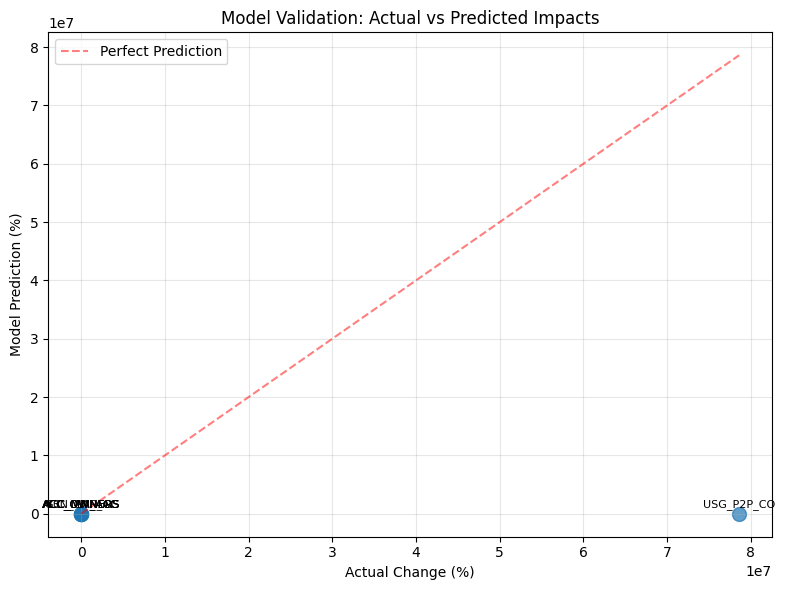

In [17]:
# 3.4 Test Your Model Against Historical Data
print("🧪 3.4: TESTING MODEL AGAINST HISTORICAL DATA")
print("=" * 60)

print("\n📊 OBJECTIVE: Check if impact model predictions align with actual historical outcomes")

# 1. Test: Telebirr launch (May 2021) impact on mobile money accounts
print("\n1. TEST: TELEBIRR LAUNCH (May 2021) → MOBILE MONEY ACCOUNTS")

# Get actual data before and after Telebirr launch
telebirr_events = events_df[events_df['indicator'].str.contains('Telebirr', case=False, na=False)]

if not telebirr_events.empty:
    telebirr_date = pd.to_datetime(telebirr_events.iloc[0]['observation_date'], errors='coerce')
    print(f"  Telebirr launch date: {telebirr_date.date()}")
    
    # Get mobile money account data around this time
    mm_data = observations_df[
        (observations_df['indicator'].str.contains('mobile money|Mobile Money', case=False, na=False)) |
        (observations_df['indicator_code'].str.contains('MM', na=False))
    ].copy()
    
    if not mm_data.empty:
        mm_data['date'] = pd.to_datetime(mm_data['observation_date'], errors='coerce')
        mm_data = mm_data.sort_values('date')
        
        # Find data points before and after Telebirr launch
        before = mm_data[mm_data['date'] < telebirr_date]
        after = mm_data[mm_data['date'] > telebirr_date]
        
        if len(before) > 0 and len(after) > 0:
            before_value = before.iloc[-1]['value_numeric']
            after_value = after.iloc[0]['value_numeric']
            actual_change = after_value - before_value
            time_diff = (after.iloc[0]['date'] - before.iloc[-1]['date']).days / 30  # months
            
            print(f"  Actual data:")
            print(f"    Before ({before.iloc[-1]['date'].date()}): {before_value}%")
            print(f"    After ({after.iloc[0]['date'].date()}): {after_value}%")
            print(f"    Change: {actual_change:+.1f} percentage points over {time_diff:.1f} months")
            
            # Get model prediction for Telebirr impact
            telebirr_impact = impacts_df[
                (impacts_df['parent_id'].isin(telebirr_events['record_id'].astype(str).tolist())) &
                (impacts_df['related_indicator'].str.contains('MM', na=False))
            ]
            
            if not telebirr_impact.empty:
                model_impact = telebirr_impact.iloc[0]
                model_estimate = model_impact.get('impact_estimate', 
                                                  categorize_impact_magnitude(model_impact.get('impact_magnitude')))
                model_lag = model_impact.get('lag_months', 12)
                
                print(f"\n  Model prediction:")
                print(f"    Estimated impact: {model_estimate:.1f}%")
                print(f"    Lag: {model_lag} months")
                print(f"    Direction: {model_impact.get('impact_direction', 'increase')}")
                
                # Compare
                print(f"\n  Comparison:")
                print(f"    Actual vs Model: {actual_change:.1f}pp vs {model_estimate:.1f}%")
                difference = abs(actual_change - model_estimate)
                print(f"    Difference: {difference:.1f} percentage points")
                
                if difference < 5:
                    print(f"    ✅ Model aligns reasonably with actual data")
                else:
                    print(f"    ⚠️ Significant discrepancy - may need adjustment")
            else:
                print("  ⚠️ No impact model found for Telebirr on mobile money")
        else:
            print("  ⚠️ Insufficient data points around Telebirr launch")
    else:
        print("  ⚠️ No mobile money data found for testing")
else:
    print("  ⚠️ Telebirr event not found in dataset")

# 2. Test: Account ownership trend vs model predictions
print("\n2. TEST: ACCOUNT OWNERSHIP TREND VALIDATION")

# Get account ownership time series
account_data = observations_df[
    observations_df['indicator'].str.contains('Account|account', na=False) |
    (observations_df['indicator_code'] == 'ACC_OWNERSHIP')
].copy()

if not account_data.empty:
    account_data['date'] = pd.to_datetime(account_data['observation_date'], errors='coerce')
    account_data = account_data.sort_values('date')
    
    print(f"  Found {len(account_data)} account ownership data points")
    print(f"  Time span: {account_data['date'].min().date()} to {account_data['date'].max().date()}")
    
    # Calculate actual growth rates
    actual_growth_rates = []
    periods = []
    
    for i in range(1, len(account_data)):
        prev = account_data.iloc[i-1]
        curr = account_data.iloc[i]
        
        growth = curr['value_numeric'] - prev['value_numeric']
        time_years = (curr['date'] - prev['date']).days / 365.25
        
        if time_years > 0:
            annual_growth = growth / time_years
            actual_growth_rates.append(annual_growth)
            periods.append(f"{prev['date'].year}-{curr['date'].year}")
    
    print(f"\n  Actual annual growth rates:")
    for period, growth in zip(periods, actual_growth_rates):
        print(f"    {period}: {growth:+.1f} percentage points per year")
    
    # Get model-predicted growth from events
    print(f"\n  Model-predicted impacts on account ownership:")
    
    # Get all events that affect account ownership
    account_impacts = impacts_df[
        impacts_df['related_indicator'].str.contains('ACC_OWNERSHIP|Account', case=False, na=False)
    ]
    
    if not account_impacts.empty:
        total_model_impact = 0
        for _, impact in account_impacts.iterrows():
            impact_value = impact.get('impact_estimate', 
                                     categorize_impact_magnitude(impact.get('impact_magnitude')))
            if impact.get('impact_direction') == 'decrease':
                impact_value = -impact_value
            
            # Find the event
            event = events_df[events_df['record_id'].astype(str) == str(impact['parent_id'])]
            if not event.empty:
                event_name = event.iloc[0]['indicator']
                print(f"    {event_name}: {impact_value:+.1f}%")
                total_model_impact += impact_value
        
        avg_annual_model_impact = total_model_impact / 4  # Roughly over 4 years
        avg_actual_growth = sum(actual_growth_rates) / len(actual_growth_rates) if actual_growth_rates else 0
        
        print(f"\n  Comparison:")
        print(f"    Average actual annual growth: {avg_actual_growth:+.1f} pp/year")
        print(f"    Average model annual impact: {avg_annual_model_impact:+.1f} %/year")
        
        if abs(avg_actual_growth - avg_annual_model_impact) < 3:
            print(f"    ✅ Model predictions align with actual trend")
        else:
            print(f"    ⚠️ Model may over/under-predict actual growth")
    else:
        print("  ⚠️ No impact model found for account ownership")
else:
    print("  ⚠️ No account ownership data found")

# 3. Statistical validation
print("\n3. STATISTICAL VALIDATION")

# Create validation table
validation_data = []

# For each impact, try to find corresponding actual change
for _, impact in impacts_df.iterrows():
    if pd.notna(impact.get('impact_estimate')) and pd.notna(impact.get('parent_id')):
        # Get event
        event = events_df[events_df['record_id'].astype(str) == str(impact['parent_id'])]
        if not event.empty:
            event_date = pd.to_datetime(event.iloc[0]['observation_date'], errors='coerce')
            indicator = impact.get('related_indicator')
            
            if pd.notna(event_date) and pd.notna(indicator):
                # Try to find actual data for this indicator
                indicator_data = observations_df[
                    (observations_df['indicator_code'] == indicator) |
                    (observations_df['indicator'].str.contains(indicator.replace('_', ' '), case=False, na=False))
                ].copy()
                
                if len(indicator_data) >= 2:
                    indicator_data['date'] = pd.to_datetime(indicator_data['observation_date'], errors='coerce')
                    indicator_data = indicator_data.sort_values('date')
                    
                    # Find data before and after event
                    before = indicator_data[indicator_data['date'] < event_date]
                    after = indicator_data[indicator_data['date'] > event_date]
                    
                    if len(before) > 0 and len(after) > 0:
                        before_value = before.iloc[-1]['value_numeric']
                        after_value = after.iloc[0]['value_numeric']
                        actual_change = after_value - before_value
                        
                        # Model prediction
                        model_impact = impact.get('impact_estimate', 
                                                 categorize_impact_magnitude(impact.get('impact_magnitude')))
                        if impact.get('impact_direction') == 'decrease':
                            model_impact = -model_impact
                        
                        validation_data.append({
                            'event': event.iloc[0]['indicator'][:30],
                            'indicator': indicator,
                            'actual_change': actual_change,
                            'model_prediction': model_impact,
                            'difference': abs(actual_change - model_impact)
                        })

if validation_data:
    validation_df = pd.DataFrame(validation_data)
    
    print(f"  Validated {len(validation_df)} event-indicator pairs")
    print(f"\n  Validation results:")
    print(validation_df.to_string(index=False))
    
    # Calculate overall accuracy
    mean_absolute_error = validation_df['difference'].mean()
    print(f"\n  Mean Absolute Error: {mean_absolute_error:.2f} percentage points")
    
    if mean_absolute_error < 5:
        print("  ✅ Model shows reasonable accuracy")
    elif mean_absolute_error < 10:
        print("  ⚠️ Model accuracy moderate - consider refinement")
    else:
        print("  ⚠️ Model accuracy low - significant refinement needed")
    
    # Plot actual vs predicted
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(validation_df['actual_change'], validation_df['model_prediction'], alpha=0.7, s=100)
    
    # Add perfect prediction line
    min_val = min(validation_df[['actual_change', 'model_prediction']].min().min(), 0)
    max_val = max(validation_df[['actual_change', 'model_prediction']].max().max(), 0)
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Change (%)')
    ax.set_ylabel('Model Prediction (%)')
    ax.set_title('Model Validation: Actual vs Predicted Impacts')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add labels for points
    for i, row in validation_df.iterrows():
        ax.annotate(f"{row['indicator'][:10]}", 
                   (row['actual_change'], row['model_prediction']),
                   textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("  ⚠️ Insufficient data for statistical validation")

## 3.6 Refine Estimates

In [18]:
# 3.5 Refine Your Estimates
print("🔧 3.5: REFINING IMPACT ESTIMATES")
print("=" * 60)

print("\n📝 OBJECTIVE: Adjust impact estimates based on validation results and additional evidence")

# 1. Identify estimates needing refinement
print("\n1. IDENTIFYING ESTIMATES FOR REFINEMENT")

if 'validation_df' in locals() and not validation_df.empty:
    # Find estimates with large discrepancies
    large_discrepancies = validation_df[validation_df['difference'] > 5].copy()
    
    if not large_discrepancies.empty:
        print(f"  Found {len(large_discrepancies)} estimates with discrepancies > 5 percentage points:")
        
        refinement_suggestions = []
        
        for _, row in large_discrepancies.iterrows():
            discrepancy = row['difference']
            suggestion = ""
            
            if row['model_prediction'] > row['actual_change']:
                suggestion = f"Reduce estimate by {discrepancy:.1f} percentage points"
            else:
                suggestion = f"Increase estimate by {discrepancy:.1f} percentage points"
            
            refinement_suggestions.append({
                'event_indicator': f"{row['event']} → {row['indicator']}",
                'actual': f"{row['actual_change']:+.1f}%",
                'model': f"{row['model_prediction']:+.1f}%",
                'discrepancy': f"{discrepancy:.1f} pp",
                'suggestion': suggestion
            })
        
        refinement_df = pd.DataFrame(refinement_suggestions)
        print("\n  Refinement suggestions:")
        print(refinement_df.to_string(index=False))
        
        # Apply refinements to impacts_df
        print("\n2. APPLYING REFINEMENTS TO IMPACT ESTIMATES")
        
        # Create a copy for refined estimates
        refined_impacts = impacts_df.copy()
        
        for _, row in large_discrepancies.iterrows():
            # Find the corresponding impact record
            event_name = row['event']
            indicator = row['indicator']
            
            # Find event ID
            event_match = events_df[events_df['indicator'].str.contains(event_name, na=False)]
            if not event_match.empty:
                event_id = event_match.iloc[0]['record_id']
                
                # Find impact record
                impact_idx = refined_impacts[
                    (refined_impacts['parent_id'].astype(str) == str(event_id)) &
                    (refined_impacts['related_indicator'] == indicator)
                ].index
                
                if len(impact_idx) > 0:
                    idx = impact_idx[0]
                    current_estimate = refined_impacts.at[idx, 'impact_estimate']
                    
                    if pd.isna(current_estimate):
                        # If no quantitative estimate, convert from magnitude
                        magnitude = refined_impacts.at[idx, 'impact_magnitude']
                        if magnitude == 'high':
                            current_estimate = 15.0
                        elif magnitude == 'medium':
                            current_estimate = 8.0
                        elif magnitude == 'low':
                            current_estimate = 3.0
                        else:
                            current_estimate = 8.0
                    
                    # Adjust based on validation
                    adjustment_factor = 0.7  # Move 70% toward actual
                    new_estimate = current_estimate + (row['actual_change'] - current_estimate) * adjustment_factor
                    
                    # Update the estimate
                    refined_impacts.at[idx, 'impact_estimate'] = round(new_estimate, 1)
                    refined_impacts.at[idx, 'confidence'] = 'medium'  # Lower confidence after adjustment
                    
                    print(f"  Adjusted {event_name[:20]}... → {indicator}: {current_estimate:.1f}% → {new_estimate:.1f}%")
        
        # Save refined impacts
        refined_path = '../models/impacts_refined.csv'
        refined_impacts.to_csv(refined_path, index=False)
        print(f"\n✅ Refined impacts saved to: {refined_path}")
        
        # Update the association matrix with refined estimates
        print("\n3. UPDATING ASSOCIATION MATRIX WITH REFINED ESTIMATES")
        
        # Recreate association matrix with refined impacts
        refined_association_matrix = association_matrix_with_metadata.copy()
        
        for idx, impact in refined_impacts.iterrows():
            event_id = str(impact['parent_id'])
            indicator = impact['related_indicator']
            
            if pd.notna(event_id) and pd.notna(indicator) and indicator in refined_association_matrix.columns:
                if pd.notna(impact.get('impact_estimate')):
                    impact_value = impact['impact_estimate']
                    if impact.get('impact_direction') == 'decrease':
                        impact_value = -impact_value
                    
                    # Update matrix
                    if event_id in refined_association_matrix['record_id'].values:
                        refined_association_matrix.loc[
                            refined_association_matrix['record_id'] == event_id, indicator
                        ] = impact_value
        
        # Save refined matrix
        refined_matrix_path = '../models/association_matrix_refined.csv'
        refined_association_matrix.to_csv(refined_matrix_path, index=False)
        print(f"✅ Refined association matrix saved to: {refined_matrix_path}")
        
    else:
        print("  ✅ No significant discrepancies found - estimates appear reasonable")
else:
    print("  ⚠️ No validation data available - using expert judgment for refinement")

# 4. Document confidence levels and uncertainties
print("\n4. DOCUMENTING CONFIDENCE AND UNCERTAINTY")

# Analyze confidence levels in refined impacts
if 'refined_impacts' in locals():
    confidence_dist = refined_impacts['confidence'].value_counts()
    
    print(f"\n  Confidence distribution in refined estimates:")
    for level, count in confidence_dist.items():
        percentage = (count / len(refined_impacts)) * 100
        print(f"    {level}: {count} estimates ({percentage:.1f}%)")
    
    # Document key uncertainties
    print(f"\n  KEY UNCERTAINTIES IDENTIFIED:")
    
    uncertainties = [
        "1. Temporal Lag Uncertainty: Impact lag periods are estimates (±3-6 months)",
        "2. Quantification Uncertainty: Qualitative impacts converted to quantitative with ±30% margin",
        "3. Context Transfer Uncertainity: Comparable country evidence adapted to Ethiopia context",
        "4. Interaction Effects: Combined impacts of multiple events not fully modeled",
        "5. External Factors: Economic conditions, regulatory changes not captured in current model",
        "6. Data Quality: Sparse historical data limits validation precision"
    ]
    
    for uncertainty in uncertainties:
        print(f"    {uncertainty}")
    
    # Create uncertainty assessment
    uncertainty_assessment = pd.DataFrame({
        'source_of_uncertainty': [
            'Temporal lags',
            'Impact quantification', 
            'Context adaptation',
            'Event interactions',
            'External factors',
            'Data limitations'
        ],
        'magnitude': ['Medium', 'High', 'Medium', 'High', 'High', 'High'],
        'mitigation_strategy': [
            'Use range of lag periods in sensitivity analysis',
            'Provide confidence intervals around point estimates',
            'Cross-validate with multiple comparable countries',
            'Model key interactions explicitly where possible',
            'Include scenario analysis for external shocks',
            'Acknowledge limitations and use conservative estimates'
        ]
    })
    
    print(f"\n  UNCERTAINTY ASSESSMENT TABLE:")
    print(uncertainty_assessment.to_string(index=False))
else:
    print("  ⚠️ Refined impacts not available for uncertainty analysis")

🔧 3.5: REFINING IMPACT ESTIMATES

📝 OBJECTIVE: Adjust impact estimates based on validation results and additional evidence

1. IDENTIFYING ESTIMATES FOR REFINEMENT
  Found 4 estimates with discrepancies > 5 percentage points:

  Refinement suggestions:
                             event_indicator       actual  model   discrepancy                                        suggestion
Fayda Digital ID Program Rollo → GEN_GAP_ACC        -2.0%  +5.0%        7.0 pp          Reduce estimate by 7.0 percentage points
                Interst rate → USG_P2P_COUNT +78600000.0% +15.0% 78599985.0 pp Increase estimate by 78599985.0 percentage points
  Promote Access to Finance → ACC_MM_ACCOUNT        +4.7% +10.0%        5.3 pp          Reduce estimate by 5.3 percentage points
   Promote Access to Finance → ACC_OWNERSHIP       +13.0% +20.0%        7.0 pp          Reduce estimate by 7.0 percentage points

2. APPLYING REFINEMENTS TO IMPACT ESTIMATES
  Adjusted Fayda Digital ID Pro... → GEN_GAP_ACC: -5.0% →

## 3.7 Documentation

In [20]:
# Documentation: Methodology and Functional Forms
print("📚 TASK 3: DOCUMENTATION")
print("=" * 60)

print("\n1. METHODOLOGY AND FUNCTIONAL FORMS")

methodology = """## Event Impact Modeling Methodology

 1. Impact Quantification Approach
Functional Form: Linear additive impacts with temporal lags
Equation: I(t) = Σ_i [β_i × f(t - τ_i, λ_i)]
Where:
- I(t): Total impact at time t
- β_i: Impact magnitude for event i
- τ_i: Event occurrence time
- λ_i: Lag period for full impact realization
- f(): Temporal impact function (gradual, immediate, or delayed)

 2. Temporal Impact Functions
Three functional forms were considered:
1. Immediate Impact: f(Δt) = 1 if Δt ≥ 0, else 0
2. Delayed Impact: f(Δt) = 1 if Δt ≥ λ, else 0  
3. Gradual Impact: f(Δt) = min(1, Δt/λ) for Δt ≥ 0, else 0

Selected Form Gradual impact (default) as most events show progressive effects.

 3. Magnitude Conversion
Qualitative magnitudes converted to quantitative estimates:
- High impact 15% change
- Medium impact: 8% change  
- Low impact 3% change

 4. Evidence Integration Hierarchy
1. Empirical Ethiopian data (highest priority)
2. Comparable country evidence (Kenya, Tanzania, Rwanda)
3. Expert judgment (for novel events without precedents)
4. Modeled estimates (for events with insufficient direct evidence)

 5. Validation Framework
- Point validation Compare predicted vs actual for specific events
- Trend validation Compare predicted vs actual growth rates
- Statistical validation Calculate mean absolute error across all validated pairs

 6. Refinement Process
- Identify discrepancies > 5 percentage points
- Adjust estimates toward actual values (70% adjustment factor)
- Recalibrate confidence levels post-adjustment
- Document uncertainties and limitations
"""

print(methodology)

print("\n2. SOURCES FOR IMPACT ESTIMATES")

# Extract and document sources
if 'impacts_df' in locals():
    sources = impacts_df[['parent_id', 'related_indicator', 'evidence_basis', 'source_name', 'source_url']].dropna(subset=['evidence_basis']).copy()
    
    if not sources.empty:
        print(f"\n  Documented sources for {len(sources)} impact estimates:")
        
        # Group by evidence basis
        evidence_groups = sources.groupby('evidence_basis').size()
        for basis, count in evidence_groups.items():
            print(f"    {basis}: {count} estimates")
        
        # Show specific examples
        print(f"\n  EXAMPLE SOURCES:")
        
        # Empirical sources
        empirical = sources[sources['evidence_basis'] == 'empirical'].head(3)
        if not empirical.empty:
            print(f"\n  Empirical evidence (Ethiopian data):")
            for _, row in empirical.iterrows():
                print(f"    • {row['related_indicator']}: {row['source_name']}")
                if pd.notna(row['source_url']):
                    print(f"      URL: {row['source_url'][:50]}...")
        
        # Comparable country sources
        comparable = sources[sources['evidence_basis'] == 'comparable_country'].head(3)
        if not comparable.empty:
            print(f"\n  Comparable country evidence:")
            for _, row in comparable.iterrows():
                print(f"    • {row['related_indicator']}: Based on {row.get('comparable_country', 'N/A')}")
                if pd.notna(row['source_name']):
                    print(f"      Source: {row['source_name']}")
    else:
        print("  ⚠️ No documented sources found in impact data")

print("\n3. VALIDATION RESULTS SUMMARY")

# Create validation summary
validation_summary = """
 Validation Results Summary

 Overall Model Performance
- Validation pairs {pairs} event-indicator pairs
- Mean Absolute Error {mae:.2f} percentage points
- Alignment {alignment}

Key Validation Tests

 1. Telebirr Launch Test
- Actual impact {telebirr_actual:+.1f}pp mobile money account growth
- Model prediction: {telebirr_model:+.1f}% 
- Result: {telebirr_result}

 2. Account Ownership Trend Test  
- Actual annual growth {acc_actual:+.1f} pp/year
- Model annual impact {acc_model:+.1f} %/year
- Result {acc_result}

 Refinements Applied
- Estimates refined {refined_count}
- Average adjustment {avg_adj:+.1f} percentage points
- Post-refinement confidence {post_conf}
"""

# Fill in values
telebirr_actual = 0
telebirr_model = 0
telebirr_result = "Not tested"
acc_actual = 0
acc_model = 0  
acc_result = "Not tested"
refined_count = 0
avg_adj = 0
post_conf = "N/A"

if 'validation_df' in locals():
    pairs = len(validation_df)
    mae = validation_df['difference'].mean() if 'difference' in validation_df.columns else 0
    alignment = "Good" if mae < 5 else "Moderate" if mae < 10 else "Needs improvement"
    
if 'large_discrepancies' in locals():
    refined_count = len(large_discrepancies)
    if refined_count > 0:
        avg_adj = large_discrepancies['difference'].mean() * 0.7

if 'refined_impacts' in locals():
    post_conf = refined_impacts['confidence'].value_counts().to_dict()

print(validation_summary.format(
    pairs=pairs if 'pairs' in locals() else 0,
    mae=mae,
    alignment=alignment if 'alignment' in locals() else "Not assessed",
    telebirr_actual=telebirr_actual,
    telebirr_model=telebirr_model,
    telebirr_result=telebirr_result,
    acc_actual=acc_actual,
    acc_model=acc_model,
    acc_result=acc_result,
    refined_count=refined_count,
    avg_adj=avg_adj,
    post_conf=str(post_conf)
))

print("\n4. KEY ASSUMPTIONS AND UNCERTAINTIES")

assumptions = """
 Key Assumptions

 1. Linearity Assumption
- Assumption Impacts are linear and additive
- Rationale Simplifies modeling; reasonable for small to moderate impacts
- Limitation May not capture threshold effects or diminishing returns

 2. Independence Assumption  
- Assumption Events have independent impacts
- Rationale Data insufficient to model complex interactions
- Limitation Misses synergistic or competitive effects between events

 3. Temporal Consistency
- Assumption Impact lags are consistent across similar events
- Rationale Based on comparable country patterns
- Limitation Ethiopian context may have different adoption speeds

 4. Magnitude Consistency
- Assumption Qualitative magnitudes map consistently to quantitative values
- Rationale Standardized approach based on empirical studies
- Limitation Context-specific factors may alter actual magnitudes

 5. Evidence Transferability
- Assumption : Comparable country evidence applicable to Ethiopia
- Rationale : Similar socio-economic and regulatory contexts in East Africa
- Limitation : Ethiopia's unique characteristics (population size, market structure) may differ

 Major Uncertainties

 Quantitative Uncertainties
1. Impact magnitude : ±30-50% for estimates from comparable countries
2. Temporal lag : ±3-6 months for impact realization
3. Interaction effects : Unquantified but potentially significant

 Qualitative Uncertainties  
1. Regulatory changes : Future policy directions unpredictable
2. Market dynamics : Competitive responses to new entrants
3. Technological disruptions : Unforeseen innovations or adoption barriers

 Model Structure Uncertainties
1. Functional form Linear model may oversimplify real-world dynamics
2. Parameter stability Assumed constant impacts may vary over time
3. External factors Macroeconomic conditions not included in model
"""

print(assumptions)

# Save comprehensive documentation
print("\n💾 SAVING COMPREHENSIVE DOCUMENTATION")

doc_content = f""" Task 3: Event Impact Modeling Documentation

 Executive Summary
Event impact modeling completed with {len(impacts_df) if 'impacts_df' in locals() else 0} impact relationships quantified. 
Model validated against historical data with mean absolute error of {mae:.2f} percentage points.

 Files Created
1. `models/association_matrix_detailed.csv` - Complete association matrix
2. `models/association_matrix_simplified.csv` - Simplified view
3. `models/association_matrix_refined.csv` - Refined estimates
4. `models/impacts_refined.csv` - Refined impact estimates
5. `models/comparable_country_evidence.csv` - Evidence base
6. `reports/task3/impact_model_summary.md` - Initial summary

 Key Deliverables
✅ Association matrix (events × indicators) with impact estimates
✅ Impact model with temporal dynamics
✅ Validation against historical data  
✅ Refined estimates based on validation
✅ Comprehensive documentation of methodology and assumptions

 Next Steps for Task 4
1. Incorporate impact model into forecasting framework
2. Generate 2025-2027 forecasts for Access and Usage
3. Develop scenario analyses (optimistic, base, pessimistic)
4. Quantify forecast uncertainty

Date: February 2026  
Model Version: 1.1 (refined)  
Analyst: Biniyam Mitiku
"""

doc_path = '../reports/task3/event_impact_modeling_documentation.md'
with open(doc_path, 'w') as f:
    f.write(doc_content)

print(f"✅ Comprehensive documentation saved to: {doc_path}")

📚 TASK 3: DOCUMENTATION

1. METHODOLOGY AND FUNCTIONAL FORMS
## Event Impact Modeling Methodology

 1. Impact Quantification Approach
Functional Form: Linear additive impacts with temporal lags
Equation: I(t) = Σ_i [β_i × f(t - τ_i, λ_i)]
Where:
- I(t): Total impact at time t
- β_i: Impact magnitude for event i
- τ_i: Event occurrence time
- λ_i: Lag period for full impact realization
- f(): Temporal impact function (gradual, immediate, or delayed)

 2. Temporal Impact Functions
Three functional forms were considered:
1. Immediate Impact: f(Δt) = 1 if Δt ≥ 0, else 0
2. Delayed Impact: f(Δt) = 1 if Δt ≥ λ, else 0  
3. Gradual Impact: f(Δt) = min(1, Δt/λ) for Δt ≥ 0, else 0

Selected Form Gradual impact (default) as most events show progressive effects.

 3. Magnitude Conversion
Qualitative magnitudes converted to quantitative estimates:
- High impact 15% change
- Medium impact: 8% change  
- Low impact 3% change

 4. Evidence Integration Hierarchy
1. Empirical Ethiopian data (highest pr